# Candidate models for ML finance

> This notebook tries to understand and explain basic candidate models for predicting stock prices, along with their assumptions and theoritical explanations

## CAPM

> **CAPM** tries to calculate the expected return of an an asset price. It uses 3 things:
1. Expected market return ( say S&P 500 in the USA which aggregates top 500 tech companies)
2. Return from a risk free security or an asset. (Say US bond treasury rate)
3. Asset's correlation or sensitivity to the market return (say S&P 500). This is also called Beta.


**Formula for CAPM**:
    
![CAPM Model](../Desktop/capm_model.png)

Terms and explanation:

* R<sub>f</sub> - Risk free asset return. This is expected to have zero standard deviation.  An example is us treasury bond yield
* ER<sub>m</sub> Expected return of investment from market (Say S&P 500) return
* B<sub>i</sub> Assets correlation with market return

The beta coefficient can be interpreted as follows:

> β =1 exactly as volatile as the market β >1 more volatile than the market β <1>0 less volatile than the market β =0 uncorrelated to the market β <0 negatively correlated to the marke



In [638]:
pip install getFamaFrenchFactors

Note: you may need to restart the kernel to use updated packages.


In [639]:
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import getFamaFrenchFactors as gff
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
TSLA = 'TSLA'
SP500 = 'SPY'
start_date = datetime(2021,1,1)
end_date = datetime(2022,12,31)
df_tsla = yf.download(TSLA,start_date,end_date)
df_sp500 = yf.download(SP500,start_date,end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [640]:
def calculate_daily_return(dataframe):
    rows = dataframe.shape[0]
    
    daily_returns = [0]
    for i in range(1,rows):
        # Percentage change in stock price per day
        daily_returns.append(((dataframe.iloc[i]['Close'] - dataframe.iloc[i-1]['Close']) / dataframe.iloc[i-1]['Close'] ) * 100) 
    # Since no data available before 0
    
    dataframe['Daily_Returns'] = daily_returns
    
    return dataframe

In [641]:
df_tsla.iloc[0]

Open         2.398200e+02
High         2.481633e+02
Low          2.390633e+02
Close        2.432567e+02
Adj Close    2.432567e+02
Volume       1.459146e+08
Name: 2021-01-04 00:00:00-05:00, dtype: float64

In [642]:

TSLA_df = calculate_daily_return(df_tsla)
SP500_df = calculate_daily_return(df_sp500)

In [643]:
TSLA_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Returns
Date,,,,,,,
2021-01-04 00:00:00-05:00,239.820007,248.163330,239.063339,243.256668,243.256668,145914600,0.000000
2021-01-05 00:00:00-05:00,241.220001,246.946671,239.733337,245.036667,245.036667,96735600,0.731737
2021-01-06 00:00:00-05:00,252.830002,258.000000,249.699997,251.993332,251.993332,134100000,2.839030
2021-01-07 00:00:00-05:00,259.209991,272.329987,258.399994,272.013336,272.013336,154496700,7.944656
2021-01-08 00:00:00-05:00,285.333344,294.829987,279.463318,293.339996,293.339996,225166500,7.840299


In [644]:
TSLA_df.Daily_Returns.mean()

-0.06147635732071198

In [645]:
SP500_df.Daily_Returns.mean()

0.014756440367071792

[Text(0.5, 1.0, 'TSLA Stock Price Return')]

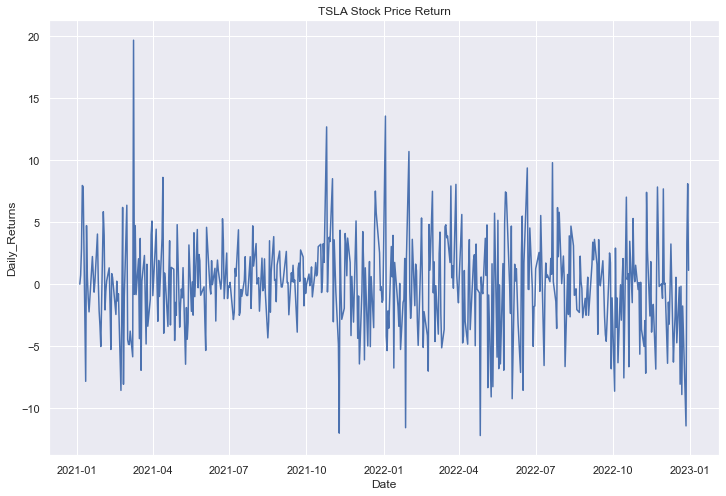

In [646]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(y=TSLA_df.Daily_Returns,x=TSLA_df.index).set(title = 'TSLA Stock Price Return')

[Text(0.5, 1.0, 'SP500 Stock Price Return')]

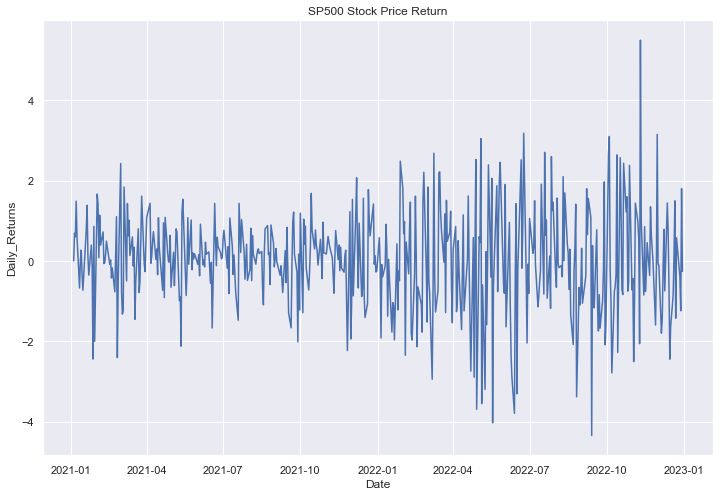

In [647]:
sns.lineplot(y=SP500_df.Daily_Returns,x=TSLA_df.index).set(title = 'SP500 Stock Price Return')

In [648]:
## Fit a polynomial to sp 500 and and TSLA
beta, alpha = np.polyfit(SP500_df.Daily_Returns,TSLA_df.Daily_Returns,1)
print('Beta for {} stock is = {} and alpha is = {}'.format('TSLA', round(beta,3), round(alpha,3)))

Beta for TSLA stock is = 1.783 and alpha is = -0.088


Text(0, 0.5, 'Tesla Daily returns')

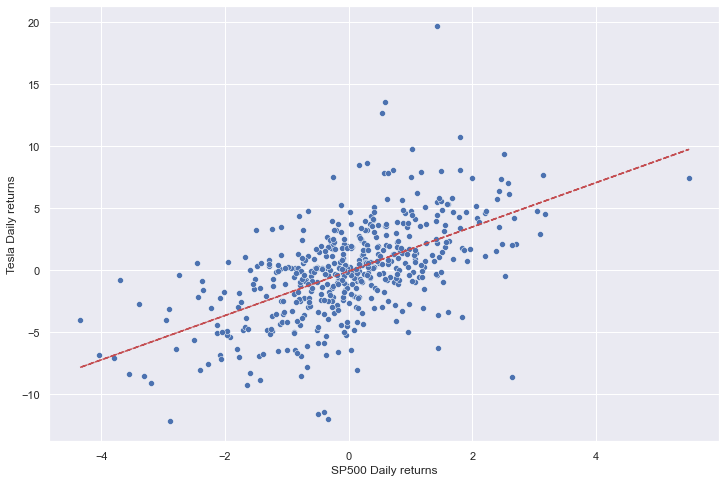

In [662]:
sns.scatterplot(x=SP500_df.Daily_Returns,y=TSLA_df.Daily_Returns)
plt.plot(SP500_df.Daily_Returns,beta * SP500_df.Daily_Returns + alpha, '--', color = 'r')
plt.xlabel("SP500 Daily returns")
plt.ylabel("Tesla Daily returns")

## Calculating Expected return based on CAPM

In [650]:
#  https://tradingeconomics.com/united-states/government-bond-yield
rf = 3.40

#  calculate the annualized rate of return for S&P500 
# Note that out of 365 days/year, stock exchanges are closed for 104 days during weekend days (Saturday and Sunday) 
rm = round(SP500_df.Daily_Returns.mean() * 252 * 2,3)

In [651]:
print(" Beta = ",beta)
#  https://tradingeconomics.com/united-states/government-bond-yield
print(" rf = ",rf)
print("rm = ",rm)

 Beta =  1.7829394324787002
 rf =  3.4
rm =  7.437


In [652]:
Expected_Return_Tesla = round(rf + (beta * ( rm - rf)),3)
print(Expected_Return_Tesla)

10.598


## Ridge Regression using selected model features




In [658]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import getFamaFrenchFactors as gff
import statsmodels.api as sm
from ta.momentum import RSIIndicator
from ta.trend import MACD

from datetime import datetime

dateparser = lambda x: datetime.strptime(x, '%Y:%m:%d')

# Download  stock data for following days
start_date = datetime(2019,1,1)
end_date = datetime(2022,1,1)
ticker = "TSLA"


df = yf.download(ticker, start=start_date, end=end_date)
ada = yf.download('ADA-USD', start=start_date, end=end_date)

ads_data = pd.read_excel("ads_index_010622.xlsx", parse_dates=['Date'], date_parser=dateparser)
new_ads_data = ads_data[['Date', 'ADS_INDEX_010622']].set_index('Date')

# Reset index and convert all dates to same timezones, so they become mergable
for x in [ada,new_ads_data]:
    x.reset_index(inplace=True)
    x['Date'] =  pd.to_datetime(x['Date']).dt.date





# Calculate Fama French 3 factors
ff_data = gff.famaFrench3Factor(frequency='m') 


ff_data.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_data.set_index('Date',inplace=True)
ff_data = ff_data.resample('D').interpolate()
ff_data.tz_localize(None)
ff_data.reset_index(inplace=True)
df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date']).dt.date
ff_data['Date'] = pd.to_datetime(ff_data['Date']).dt.date

# Merge data together to create dataframe
df = ff_data.merge(df,on='Date')
df = new_ads_data.merge(df,on='Date')




df['Fama_French_Mkt_RF'] = ff_data['Mkt-RF']
df['Fama_French_SMB'] = ff_data['SMB']
df['Fama_French_HML'] = ff_data['HML']



# Calculate additional features
df['mom_60_200'] = (df['Close'] / df['Close'].shift(60)) - 1

rsi_indicator = RSIIndicator(close=df['Adj Close'], window=14)
macd_indicator = MACD(close=df['Adj Close'])

df['rsi'] = rsi_indicator.rsi()
df['macd'] = macd_indicator.macd()

df_pca = pd.DataFrame({ 
                       'avg_close_20_days_': df['Adj Close'].rolling(window=20).mean().shift(1),
                       'Mkt-RF': df['Fama_French_Mkt_RF'].shift(1), 
                       'HML': df['Fama_French_HML'].shift(1), 
                       'RSI': df['rsi'].shift(1),
                       'MACD': df['macd'].shift(1),
                       'ADA_ADJ_CLOSE': ada['Adj Close'].shift(1),
                       'ADS_INDEX': df['ADS_INDEX_010622'].shift(1),
                       'mom_60_200': df['mom_60_200'].shift(1),
                        'Adj Close': df['Adj Close'],
    'Date': df['Date']
                       })


# Dropping null values
df_pca.dropna(inplace=True)
df_copy = df_pca.copy()




closing_price = df_pca['Adj Close']
df_pca = df_pca.drop(columns=['Adj Close','Date'],axis=1)


# Applying PCA
scaler = StandardScaler()




# Fit the scaler and PCA on the data
X = scaler.fit_transform(df_pca)




from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, closing_price.values,test_size=0.2, random_state=42,shuffle=False)
# train_y, test_y = closing_price.values[:train_size], closing_price.values[train_size:]

# Training the linear regression model
reg =  Ridge(alpha=-0.18)
reg.fit(X_train, y_train)



# Predicting on test data
test_pred = reg.predict(X_test)



test_pred = test_pred.reshape(-1, 1)

# Calculating regression metrics
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
r2 = r2_score(y_test, test_pred)

print("RMSE: ", rmse)
print("R Squared: ", r2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
RMSE:  17.59897219870921
R Squared:  0.9136865121115817


In [659]:
pred_all = reg.predict(X)
df_plot = df_copy[['Date','Adj Close']]
df_plot['Predicted Close'] = pred_all
df_plot['Diff Close'] =  df_plot['Predicted Close'] - df_plot['Adj Close'] 



/var/folders/2s/jbd9m2gj61n3fk0zl36lyp940000gn/T/ipykernel_30948/4009436875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Predicted Close'] = pred_all
/var/folders/2s/jbd9m2gj61n3fk0zl36lyp940000gn/T/ipykernel_30948/4009436875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Diff Close'] =  df_plot['Predicted Close'] - df_plot['Adj Close']


In [655]:
sum(df_plot['Diff Close'])

249.34941028423782

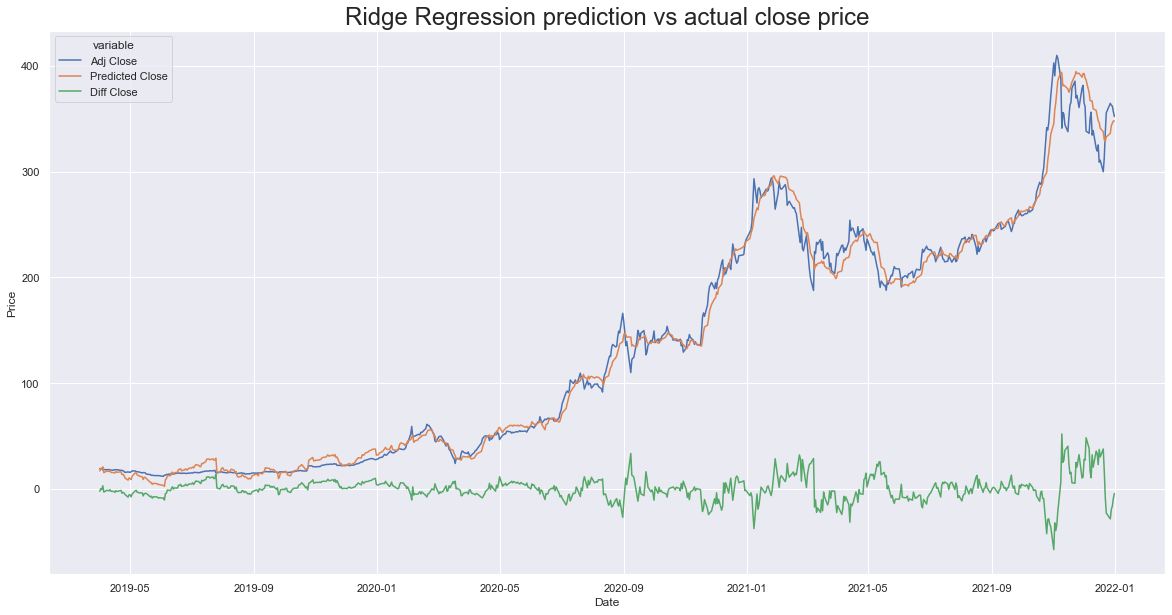

In [661]:
plt.figure(figsize = ( 20 , 10 ))
  # Set title for figure
plt.title( 'Ridge Regression prediction vs actual close price' , size = 24 )
   
sns.lineplot(x='Date', y='value', hue='variable', 
             data=pd.melt(df_plot, ['Date']))
plt.ylabel("Price")
# Display figure
plt.show() 
